<a href="https://colab.research.google.com/github/eeyamazaki/soebe/blob/main/modelo_preditivo_soebe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [563]:
# Importando as bibliotecas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [564]:
# Lendo a base dos serviços de reposição da contratada SOEBE:
# Base de serviços retirada da transação ZSBPM020 para as unidades: 277 e 273.
# skiprows = 3, pois as 3 primeiras linhas sao cabecalho.

dfSoebe = pd.read_csv(r'/content/drive/MyDrive/Projetos/soebe/pendentes-soebe/reposicoes.txt', encoding='cp1252', sep='|',
                      skiprows=3, dtype=object)
dfSoebe.head()

,Unnamed: 0,Ordem,Tipo ordem,Centro,Operação,CenTrab,Txt.breve operação,Cód. Único,Oper.ZSCP,TSE Oper.,...,Quantidade,Extensão,MND,L.Corte/Su,Religação,Mt.Cúbico,Observação,StatSist,StatUsuár.,Unnamed: 54
0,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2206463343,ZSCP,0004,0050,277CRB04,REPOSIÇÃO DE ASFALTO INV,226463343,0050,733000,...,,"0,00",,,,,...,LIB,EXEC VALO,NaN
2,NaN,2207236897,ZSCP,0004,0040,273CRL07,SERVIÇO EXECUTADO ANTERIORMENTE,227236897,0040,904200,...,,"0,00",,,,,"Conforme vistoria em 06.08.22, servico executa...",LIB,NEXE VALO,NaN
3,NaN,2210680011,ZSCP,0004,0030,277CRB04,REPOSIÇÃO DE ASFALTO INV,2210680011,0030,733000,...,,"0,00",,,,,...,LIB,EXEC VALO,NaN
4,NaN,2212237908,ZSCP,0004,0050,273CRL10,REPOSIÇÃO DE CAPA ASFALTICA INV,2212237908,0050,745000,...,,"0,00",,,,,...,LIB,EXEC VALO,NaN


In [565]:
# Como o cabecalho possui um excesso de espacos, vamos e renomeá-los:

l1 = dfSoebe.columns
l1 = [x.strip(' ') for x in l1]

dfSoebe = dfSoebe.rename(columns=dict(zip(dfSoebe.columns, l1)))
dfSoebe.columns

Index(['Unnamed: 0', 'Ordem', 'Tipo ordem', 'Centro', 'Operação', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSE Oper.', 'TSS',
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.',
       'Comp.', 'Largura', 'Profund.', 'Quantidade', 'Extensão', 'MND',
       'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação', 'StatSist',
       'StatUsuár.', 'Unnamed: 54'],
      dtype='object')

In [566]:
# Removendo excesso de espaços das colunas:

for i in l1:
  dfSoebe[i] = dfSoebe[i].str.strip()

In [567]:
# Missing Values
# Vamos remover os missing para as linhas em que não há ordem de serviço:

dfSoebe = dfSoebe.dropna(subset=['Ordem'])
dfSoebe.head()

,Unnamed: 0,Ordem,Tipo ordem,Centro,Operação,CenTrab,Txt.breve operação,Cód. Único,Oper.ZSCP,TSE Oper.,...,Quantidade,Extensão,MND,L.Corte/Su,Religação,Mt.Cúbico,Observação,StatSist,StatUsuár.,Unnamed: 54
1,NaN,2206463343,ZSCP,0004,0050,277CRB04,REPOSIÇÃO DE ASFALTO INV,226463343,0050,733000,...,,"0,00",,,,,,LIB,EXEC VALO,NaN
2,NaN,2207236897,ZSCP,0004,0040,273CRL07,SERVIÇO EXECUTADO ANTERIORMENTE,227236897,0040,904200,...,,"0,00",,,,,"Conforme vistoria em 06.08.22, servico executa...",LIB,NEXE VALO,NaN
3,NaN,2210680011,ZSCP,0004,0030,277CRB04,REPOSIÇÃO DE ASFALTO INV,2210680011,0030,733000,...,,"0,00",,,,,,LIB,EXEC VALO,NaN
4,NaN,2212237908,ZSCP,0004,0050,273CRL10,REPOSIÇÃO DE CAPA ASFALTICA INV,2212237908,0050,745000,...,,"0,00",,,,,,LIB,EXEC VALO,NaN
5,NaN,2213943855,ZSCP,0004,0020,277CRL06,DUPLICIDADE,2213943855,0020,901500,...,,"0,00",,,,,problema sistema,LIB,NEXE,NaN


In [568]:
# Ficamos com as seguintes colunas no dataset de reposições:

dfSoebe.columns

Index(['Unnamed: 0', 'Ordem', 'Tipo ordem', 'Centro', 'Operação', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSE Oper.', 'TSS',
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.',
       'Comp.', 'Largura', 'Profund.', 'Quantidade', 'Extensão', 'MND',
       'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação', 'StatSist',
       'StatUsuár.', 'Unnamed: 54'],
      dtype='object')

In [569]:
# Vamos remover variáveis que não trazem valor para o nosso problema:

dfSoebe = dfSoebe.drop(['Unnamed: 0', 'Tipo ordem', 'Centro', 'CenTrab', 'Txt.breve operação',
              'Cód. Único', 'Oper.ZSCP', 'TSS', 'Cont.ZSCP', 'M.Mão Obra',
              'Ag.Tp.Serv', 'Resp.ZSCP', 'DtDespacho', 'Dt.Início', 'Hr.Iniíio',
              'Hr.Fim', 'Hr.Trab.', 'Acatamento', 'Hr.Acatam.',
              'Dt.Agend.', 'Turno', 'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.',
              'Dt.Fim', 'Hr.Fim  .1', 'H.Retirado', 'Instalado', 'Garantia',
              'Dt.Exec.', 'Hr.Exec.', 'Peso', 'Tipo Mat.', 'Pos. Rede',
              'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.', 'Quantidade', 'Extensão',
              'MND', 'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação',
              'Unnamed: 54'], axis=1)

dfSoebe.head()

,Ordem,Operação,TSE Oper.,Un. Adm.,Dt.FimExec,Comp.,Largura,Profund.,StatSist,StatUsuár.
1,2206463343,0050,733000,277,14.07.2022,"1,00","1,00","0,00",LIB,EXEC VALO
2,2207236897,0040,904200,273,06.08.2022,"0,00","0,00","0,00",LIB,NEXE VALO
3,2210680011,0030,733000,277,14.07.2022,"2,00","1,50","0,00",LIB,EXEC VALO
4,2212237908,0050,745000,273,13.09.2022,"1,00","1,00","3,00",LIB,EXEC VALO
5,2213943855,0020,901500,277,16.09.2022,"0,00","0,00","0,00",LIB,NEXE


In [570]:
# Lendo a base de servicos liberados no SAP para o contrato do Global:

# skiprows = 3, pois as 3 primeiras linhas sao cabecalho.

dfGlobal = pd.read_csv(r'/content/drive/MyDrive/Projetos/soebe/pendentes-global/global.txt', 
                 encoding='cp1252', on_bad_lines='skip', skiprows=3, sep='|', dtype=object)
dfGlobal.head()

,Unnamed: 0,Ordem,Tipo ordem,Centro,Operação,CenTrab,Txt.breve operação,Cód. Único,Oper.ZSCP,TSE Oper.,...,Quantidade,Extensão,MND,L.Corte/Su,Religação,Mt.Cúbico,Observação,StatSist,StatUsuár.,Unnamed: 54
0,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2110062824,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110062824,0010,903000,...,,"0,00",,,,,...,LIB,NEXE,NaN
2,NaN,2110063329,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110063329,0010,903000,...,,"0,00",,,,,...,LIB,NEXE,NaN
3,NaN,2110063740,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110063740,0010,903000,...,,"0,00",,,,,...,LIB,NEXE,NaN
4,NaN,2110064727,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110064727,0010,903000,...,,"0,00",,,,,...,LIB,NEXE,NaN


In [571]:
# Como o cabecalho possui um excesso de espaços, vamos removê-los e renomeá-los:

l1 = dfGlobal.columns
l1 = [x.strip(' ') for x in l1]

dfGlobal = dfGlobal.rename(columns=dict(zip(dfGlobal.columns, l1)))

dfGlobal.columns

Index(['Unnamed: 0', 'Ordem', 'Tipo ordem', 'Centro', 'Operação', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSE Oper.', 'TSS',
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.',
       'Comp.', 'Largura', 'Profund.', 'Quantidade', 'Extensão', 'MND',
       'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação', 'StatSist',
       'StatUsuár.', 'Unnamed: 54'],
      dtype='object')

In [572]:
# Removendo o excesso de espacos no dataframe:

for i in l1:
  dfGlobal[i] = dfGlobal[i].str.strip()

In [573]:
# Missing Values:
# Removendo missing values pela Ordem no dataframe.

dfGlobal = dfGlobal.dropna(subset=['Ordem'])
dfGlobal.head()

,Unnamed: 0,Ordem,Tipo ordem,Centro,Operação,CenTrab,Txt.breve operação,Cód. Único,Oper.ZSCP,TSE Oper.,...,Quantidade,Extensão,MND,L.Corte/Su,Religação,Mt.Cúbico,Observação,StatSist,StatUsuár.,Unnamed: 54
1,NaN,2110062824,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110062824,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN
2,NaN,2110063329,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110063329,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN
3,NaN,2110063740,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110063740,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN
4,NaN,2110064727,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110064727,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN
5,NaN,2110065051,ZSCP,0004,0010,277CTA06,NADA CONSTA NO LOCAL,2110065051,0010,903000,...,,"0,00",,,,,,LIB,NEXE,NaN


In [574]:
# Ficamos com as seguintes colunas:

dfGlobal.columns

Index(['Unnamed: 0', 'Ordem', 'Tipo ordem', 'Centro', 'Operação', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSE Oper.', 'TSS',
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.',
       'Comp.', 'Largura', 'Profund.', 'Quantidade', 'Extensão', 'MND',
       'L.Corte/Su', 'Religação', 'Mt.Cúbico', 'Observação', 'StatSist',
       'StatUsuár.', 'Unnamed: 54'],
      dtype='object')

In [575]:
# Removendo as variaveis desnecessarias:

dfGlobal = dfGlobal.drop(['Unnamed: 0', 'Tipo ordem', 'Centro', 'CenTrab',
       'Txt.breve operação', 'Cód. Único', 'Oper.ZSCP', 'TSS', 
       'Cont.ZSCP', 'Un. Adm.', 'M.Mão Obra', 'Ag.Tp.Serv', 'Resp.ZSCP',
       'DtDespacho', 'Dt.Início', 'Hr.Iniíio', 'Dt.FimExec', 'Hr.Fim',
       'Hr.Trab.', 'Acatamento', 'Hr.Acatam.', 'Dt.Agend.', 'Turno',
       'Dt.Compet.', 'Dt.Susp.', 'Hr.Susp.', 'Dt.Fim', 'Hr.Fim  .1',
       'H.Retirado', 'Instalado', 'Garantia', 'Dt.Exec.', 'Hr.Exec.', 'Peso',
       'Quantidade', 'Observação', 'Unnamed: 54', 'L.Corte/Su', 'Religação'], axis=1)

dfSoebe.head()

,Ordem,Operação,TSE Oper.,Un. Adm.,Dt.FimExec,Comp.,Largura,Profund.,StatSist,StatUsuár.
1,2206463343,0050,733000,277,14.07.2022,"1,00","1,00","0,00",LIB,EXEC VALO
2,2207236897,0040,904200,273,06.08.2022,"0,00","0,00","0,00",LIB,NEXE VALO
3,2210680011,0030,733000,277,14.07.2022,"2,00","1,50","0,00",LIB,EXEC VALO
4,2212237908,0050,745000,273,13.09.2022,"1,00","1,00","3,00",LIB,EXEC VALO
5,2213943855,0020,901500,277,16.09.2022,"0,00","0,00","0,00",LIB,NEXE


In [576]:
# Quantidade de Ordens duplicadas:

# Aqui a ordem pode duplicar porque para uma mesma ordem de serviço podemos ter etapas diferentes que foram executadas:

len(dfGlobal['Ordem'])-dfGlobal['Ordem'].nunique()

14789

In [577]:
# As etapas pendentes de valoração assumem o valor StatUsuario como NEXE (não executado) ou EXEC (executado).
# NEXE não se paga, logo o valor é 0.
# EXEC a etapa foi executada e deve receber algum valor de acordo com o item de preço e análise dos serviços correlatos (extensão, largura, comprimento e outros detalhes do serviço principal).

dfGlobal['StatUsuár.'].unique()

array(['NEXE', 'EXEC VALO', 'EXEC', 'NEXE VALO'], dtype=object)

In [578]:
# Fazendo a leitura de todos os arquivos de serviços pagos pelas reposições, desde o início do contrato:

# Aqui esperamos relacionar o valor pago para cada ordem de serviço da contratada de acordo com as suas caracteristicas (extensao, largura, comprimento, servico principal atrelado, etc.)

path = r'/content/drive/MyDrive/Projetos/soebe/servicos_pagos-soebe'
filenames = glob.glob(path + "/*.txt")

dfs = []
for filename in filenames:
  dfs.append(pd.read_csv(filename, dtype=object, encoding='cp1252', sep='|',
                      skiprows=8))

dfReposicoesPagas = pd.concat(dfs, ignore_index=True)
dfReposicoesPagas.head()

,Unnamed: 0,Un. Adm.,Frente,Ordem,Etapa,TSE,Descrição do TSE,Endereço,Município,Data Fim d,...,Endereço,Descrição do Motivo de Não Pagamento,Endereço,Descrição,Pedido,Descrição do TSE,Endereço,Descrição do Motivo,Descrição do TSE,Descrição
0,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,277,04,2206463343,0050,733000,REPOSIÇÃO DE ASFALTO INV,RUA MIGUEL OSORIO DE ALMEIDA 67 C/1 VL RENATO ...,SÃO PAULO,14.07.2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,277,04,2210680011,0030,733000,REPOSIÇÃO DE ASFALTO INV,RUA JOAO RICARDO 40 C/1 JD PERI ...,SÃO PAULO,14.07.2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,277,04,2218010936,0050,733000,REPOSIÇÃO DE ASFALTO INV,RUA FRANCISCO RODRIGUES ALVES 187 VL BRUNA ...,SÃO PAULO,14.07.2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,273,,2218474146,0030,904200,SERVIÇO EXECUTADO ANTERIORMENTE,RUA PONTA GROSSA 40 P MANDAQUI ...,SÃO PAULO,22.06.2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [579]:
# Como o cabecalho possui um excesso de espaços, vamos removê-los e renomeá-los:

l1 = dfReposicoesPagas.columns
l1 = [x.strip(' ') for x in l1]

dfReposicoesPagas = dfReposicoesPagas.rename(columns=dict(zip(dfReposicoesPagas.columns, l1)))

dfReposicoesPagas.columns

Index(['Unnamed: 0', 'Un. Adm.', 'Frente', 'Ordem', 'Etapa', 'TSE',
       'Descrição do TSE', 'Endereço', 'Município', 'Data Fim d', 'Dt.Val.',
       'Pago?', 'Motivo de', 'Descrição do Motivo', 'Número de', 'Item de Pr',
       'Descrição do Item de Preço', 'UM', 'Valor Unit', 'Quantidade',
       'Compriment', 'Largura', 'Profundida', 'Valor Medi', 'Medição Pa',
       'Medição De', 'Medição De.1', 'Medição Es', 'Ajuste', 'Documento',
       'Documento.1', 'Documento.2', 'Documento.3', 'Pedido', 'Período',
       'Início', 'Fim', 'Unnamed: 37', 'Endereço',
       'Descrição do Motivo de Não Pagamento', 'Endereço', 'Descrição',
       'Pedido', 'Descrição do TSE', 'Endereço', 'Descrição do Motivo',
       'Descrição do TSE', 'Descrição'],
      dtype='object')

In [580]:
# Vamos remover as variáveis desnecessarias:

dfReposicoesPagas = dfReposicoesPagas.drop(['Unnamed: 0', 'Un. Adm.', 'Frente', 'TSE',
       'Descrição do TSE', 'Endereço', 'Município', 'Data Fim d', 'Dt.Val.',
       'Motivo de', 'Descrição do Motivo', 'Descrição do Item de Preço', 'Medição Pa',
       'Medição De', 'Medição De.1', 'Medição Es', 'Ajuste', 'Documento',
       'Documento.1', 'Documento.2', 'Documento.3', 'Pedido', 'Período',
       'Início', 'Fim', 'Unnamed: 37', 'Descrição do TSE', 'Endereço',
       'Descrição do Motivo', 'Endereço', 'Compriment', 'Largura', 'Profundida',  
       'Descrição do Motivo de Não Pagamento', 'Endereço', 'Descrição',
       'Pedido'], axis=1)

dfReposicoesPagas.head()

,Ordem,Etapa,Pago?,Número de,Item de Pr,UM,Valor Unit,Quantidade,Valor Medi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2206463343,0050,S,453897,04040204,un,"108,56","1,00","108,56"
2,2210680011,0030,S,453897,04040204,un,"108,56","1,00","108,56"
3,2218010936,0050,S,453897,04040204,un,"108,56","1,00","108,56"
4,2218474146,0030,N,,,,"0,00","0,00","0,00"


In [581]:
# Removendo valores nulos para a Ordem:
# O dataset deve ter o valor pago por cada etapa da sua respectiva ordem de serviço.
# A mesma ordem de serviço pode ter mais de um item a ser valorado.
# Devemos ficar com um dataset contendo apenas as linhas de serviços e o valor pago.

mask = (dfReposicoesPagas['Ordem']=='nan')
dfReposicoesPagas = dfReposicoesPagas[~mask]
dfReposicoesPagas = dfReposicoesPagas.dropna(subset=['Ordem'])

dfReposicoesPagas.head()

,Ordem,Etapa,Pago?,Número de,Item de Pr,UM,Valor Unit,Quantidade,Valor Medi
1,2206463343,0050,S,453897,04040204,un,"108,56","1,00","108,56"
2,2210680011,0030,S,453897,04040204,un,"108,56","1,00","108,56"
3,2218010936,0050,S,453897,04040204,un,"108,56","1,00","108,56"
4,2218474146,0030,N,,,,"0,00","0,00","0,00"
5,2218852095,0030,S,453210,01040301,un,"216,61","1,00","216,61"


In [582]:
# Removendo excesso de espacos:

l1 = dfReposicoesPagas.columns

for i in l1:
  dfReposicoesPagas[i] = dfReposicoesPagas[i].str.strip()

In [583]:
# Ficamos com o seguinte dataset de caracteristicas dos servicos pendentes ou valorados da SOEBE:

dfSoebe.head()

,Ordem,Operação,TSE Oper.,Un. Adm.,Dt.FimExec,Comp.,Largura,Profund.,StatSist,StatUsuár.
1,2206463343,0050,733000,277,14.07.2022,"1,00","1,00","0,00",LIB,EXEC VALO
2,2207236897,0040,904200,273,06.08.2022,"0,00","0,00","0,00",LIB,NEXE VALO
3,2210680011,0030,733000,277,14.07.2022,"2,00","1,50","0,00",LIB,EXEC VALO
4,2212237908,0050,745000,273,13.09.2022,"1,00","1,00","3,00",LIB,EXEC VALO
5,2213943855,0020,901500,277,16.09.2022,"0,00","0,00","0,00",LIB,NEXE


In [584]:
# Ficamos com o seguinte dataset de caracteristicas dos servicos pendentes ou valorados do Global:

dfGlobal.head()

,Ordem,Operação,TSE Oper.,Tipo Mat.,Pos. Rede,Diam.Rede,Diam.Ramal,Diam.Cavl.,Comp.,Largura,Profund.,Extensão,MND,Mt.Cúbico,StatSist,StatUsuár.
1,2110062824,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
2,2110063329,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
3,2110063740,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
4,2110064727,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
5,2110065051,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE


In [585]:
# Ficamos com o seguinte dataset de valores pagos para as reposicoes da SOEBE:

dfReposicoesPagas.head()

,Ordem,Etapa,Pago?,Número de,Item de Pr,UM,Valor Unit,Quantidade,Valor Medi
1,2206463343,0050,S,453897,04040204,un,"108,56","1,00","108,56"
2,2210680011,0030,S,453897,04040204,un,"108,56","1,00","108,56"
3,2218010936,0050,S,453897,04040204,un,"108,56","1,00","108,56"
4,2218474146,0030,N,,,,"0,00","0,00","0,00"
5,2218852095,0030,S,453210,01040301,un,"216,61","1,00","216,61"


In [586]:
# Realizando a leitura da base de serviços pagos para o contrato do Global:

path = r'/content/drive/MyDrive/Projetos/soebe/servicos_pagos-global'
filenames = glob.glob(path + "/*.txt")

dfs = []
for filename in filenames:
  dfs.append(pd.read_csv(filename, dtype=object, encoding='cp1252', sep='|',
                      skiprows=8))

dfServicosPagosGlobal = pd.concat(dfs, ignore_index=True)
dfServicosPagosGlobal.head()

,Unnamed: 0,Un. Adm.,Frente,Ordem,Etapa,TSE,Descrição do TSE,Endereço,Município,Data Fim d,...,Início,Fim,Unnamed: 37,Endereço,Endereço,Descrição do Item de Preço,Endereço,Descrição do Motivo,Descrição do Motivo de Não Pagamento,Endereço
0,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,273,02,2105325349,0010,134000,INSTALADO LACRE DIVERSOS,RUA CONDESSA SICILIANO 202 V SICILIANO ...,SÃO PAULO,19.02.2022,...,01.02.2022,28.02.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,273,06,2105530070,0020,508000,SUBSTITUIDA LIGAÇÃO DE ESGOTO,RUA ALVES PORTO 63 V MEDEIROS ...,SÃO PAULO,20.10.2021,...,01.02.2022,28.02.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,273,06,2105530070,0030,745000,REPOSIÇÃO DE CAPA ASFALTICA INV,RUA ALVES PORTO 63 V MEDEIROS ...,SÃO PAULO,20.10.2021,...,01.02.2022,28.02.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,273,,2105530070,0040,502000,LIGAÇÃO DE ESGOTO ADICIONAL,RUA ALVES PORTO 63 V MEDEIROS ...,SÃO PAULO,20.10.2021,...,01.02.2022,28.02.2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [587]:
# Como o cabecalho possui um excesso de espaços, vamos removê-los e renomeá-los:

l1 = dfServicosPagosGlobal.columns
l1 = [x.strip(' ') for x in l1]

dfServicosPagosGlobal = dfServicosPagosGlobal.rename(columns=dict(zip(dfServicosPagosGlobal.columns, l1)))

dfServicosPagosGlobal.columns

Index(['Unnamed: 0', 'Un. Adm.', 'Frente', 'Ordem', 'Etapa', 'TSE',
       'Descrição do TSE', 'Endereço', 'Município', 'Data Fim d', 'Dt.Val.',
       'Pago?', 'Motivo de', 'Descrição do Motivo', 'Número de', 'Item de Pr',
       'Descrição do Item de Preço', 'UM', 'Valor Unit', 'Quantidade',
       'Compriment', 'Largura', 'Profundida', 'Valor Medi', 'Medição Pa',
       'Medição De', 'Medição De.1', 'Medição Es', 'Ajuste', 'Documento',
       'Documento .1', 'Documento .2', 'Documento .3', 'Pedido', 'Período',
       'Início', 'Fim', 'Unnamed: 37', 'Endereço', 'Endereço',
       'Descrição do Item de Preço', 'Endereço', 'Descrição do Motivo',
       'Descrição do Motivo de Não Pagamento', 'Endereço'],
      dtype='object')

In [588]:
# Avaliando os tipos de variaveis que temos na base de serviços pagos do Global:

for coluna in dfServicosPagosGlobal.columns:
  print('=========='*30)
  print(dfServicosPagosGlobal[coluna].head())

0    ----------------------------------------------...
1                                                  NaN
2                                                  NaN
3                                                  NaN
4                                                  NaN
Name: Unnamed: 0, dtype: object
0           NaN
1           273
2           273
3           273
4           273
Name: Un. Adm., dtype: object
0       NaN
1    02    
2    06    
3    06    
4          
Name: Frente, dtype: object
0           NaN
1    2105325349
2    2105530070
3    2105530070
4    2105530070
Name: Ordem, dtype: object
0      NaN
1    0010 
2    0020 
3    0030 
4    0040 
Name: Etapa, dtype: object
0       NaN
1    134000
2    508000
3    745000
4    502000
Name: TSE, dtype: object
0                                         NaN
1    INSTALADO LACRE DIVERSOS                
2    SUBSTITUIDA LIGAÇÃO DE ESGOTO           
3    REPOSIÇÃO DE CAPA ASFALTICA INV         
4    LIGAÇÃO DE ESGOTO ADICIONAL     

In [589]:
# Vamos remover as variáveis desnecessarias:

# Vamos deixar apenas a variavel do item de preço.
# Hipótese: a etapa principal ter sido paga em despesa ou investimento implica de alguma forma no valor a ser pago pela reposição.

dfServicosPagosGlobal = dfServicosPagosGlobal.drop(['Unnamed: 0', 'Un. Adm.', 'Frente', 'TSE',
       'Descrição do TSE', 'Endereço', 'Município', 'Data Fim d', 'Dt.Val.',
       'Pago?', 'Motivo de', 'Descrição do Motivo', 'Número de',
       'Descrição do Item de Preço', 'UM', 'Valor Unit', 'Quantidade',
       'Compriment', 'Largura', 'Profundida', 'Valor Medi', 'Medição Pa',
       'Medição De', 'Medição De.1', 'Medição Es', 'Ajuste', 'Documento',
       'Documento .1', 'Documento .2', 'Documento .3', 'Pedido', 'Período',
       'Início', 'Fim', 'Unnamed: 37', 'Endereço', 'Endereço',
       'Descrição do Item de Preço', 'Endereço', 'Descrição do Motivo',
       'Descrição do Motivo de Não Pagamento', 'Endereço'], axis=1)

dfServicosPagosGlobal.head()

,Ordem,Etapa,Item de Pr
0,NaN,NaN,NaN
1,2105325349,0010,02030205
2,2105530070,0020,06140102
3,2105530070,0030,06120603
4,2105530070,0040,


In [590]:
# Removendo os espaços em branco, restando apenas as linhas com ordens de serviços:

mask = (dfServicosPagosGlobal['Ordem']=='nan')
dfServicosPagosGlobal = dfServicosPagosGlobal[~mask]
dfServicosPagosGlobal = dfServicosPagosGlobal.dropna(subset=['Ordem'])

dfServicosPagosGlobal.head()

,Ordem,Etapa,Item de Pr
1,2105325349,0010,02030205
2,2105530070,0020,06140102
3,2105530070,0030,06120603
4,2105530070,0040,
5,2105530070,0050,


In [591]:
# Removendo excesso de espacos:

l1 = dfServicosPagosGlobal.columns

for i in l1:
  dfServicosPagosGlobal[i] = dfServicosPagosGlobal[i].str.strip()

In [592]:
# Ficamos com o seguinte dataframe:

dfServicosPagosGlobal.head()

,Ordem,Etapa,Item de Pr
1,2105325349,0010,02030205
2,2105530070,0020,06140102
3,2105530070,0030,06120603
4,2105530070,0040,
5,2105530070,0050,


In [593]:
# Renomeando a coluna 'Etapa':
# Deixando a variavel com o mesmo nome do dataframe de servicos pendentes da SOEBE:

dfReposicoesPagas.rename(columns={'Etapa':'Operação'}, inplace=True)

In [594]:
# Para saber o valor pago por cada etapa de reposicao vamos realizar as seguintes etapas:

# Antes de agrupar a coluna Valor Medido, vamos transformar a variavel em tipo 'float':

# Temos valores no seguinte formato: 9.465,99

# Abordagem: 
# 1) vamos primeiro substituir o '.' por '-'
# 2) Substituir a ',' por '.'
# 3) Substituir o '-' por ''

dfReposicoesPagas['Valor Medi'] = dfReposicoesPagas['Valor Medi'].str.replace('.', '-')
dfReposicoesPagas['Valor Medi'] = dfReposicoesPagas['Valor Medi'].str.replace(',', '.')
dfReposicoesPagas['Valor Medi'] = dfReposicoesPagas['Valor Medi'].str.replace('-', '')
dfReposicoesPagas['Valor Medi'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if sys.path[0] == '':


array(['108.56', '0.00', '216.61', '139.58', '298.64', '388.36', '478.08',
       '212.88', '109.02', '652.40', '62.80', '717.77', '657.53',
       '106.44', '328.12', '358.88', '538.32', '186.27', '26.61',
       '127.36', '447.32', '857.48', '580.62', '185.03', '341913.00',
       '612.04', '565.71', '133.05', '2065.78', '14801.72', '13171.18',
       '845.90', '622499.43', '155.09', '143.53', '239.49', '565.24',
       '128.15', '153.78', '11533.50', '891.92', '480.56', '2108.07',
       '23579.60', '749.68', '196.11', '27725.47', '875588.72', '345.94',
       '17111.12', '1700.33', '17434.69', '11673.88', '69.21', '425.77',
       '159.66', '532.21', '4993.71', '103.82', '256.30', '130.71',
       '27649.33', '5710.05', '17908.65', '384.45', '9465.99', '832.98',
       '888.20', '215.29', '426.74', '179.41', '615.20', '53.22',
       '1558.30', '1357.14', '638.65', '499.79', '1915.96', '7327.90',
       '13158.49', '6217.61', '422.90', '1011.20', '1037.81', '452.38',
       '1107.2

In [595]:
# Convertendo a variavel 'Valor Medi' em 'foat':

dfReposicoesPagas['Valor Medi'] = dfReposicoesPagas['Valor Medi'].astype(float)

In [596]:
# Agrupando por Ordem e Etapa e somando o valor pago por item:

# Essa operação é realizada para os casos em que há mais de um item de preço pago pela mesma ordem de serviço e etapa:

dfReposicoesPagas = dfReposicoesPagas.groupby(['Ordem', 'Operação'])['Valor Medi'].sum()

In [597]:
# Alterando o index para Ordem e Operacao para o dataframe da Soebe:

dfSoebe.set_index(['Ordem', 'Operação'], inplace=True)

In [598]:
# Merging nos dataframes para obtermos o valor pago para cada ordem:

dfSoebe = pd.merge(dfSoebe, dfReposicoesPagas, left_index=True, right_index=True, how='left')

In [599]:
# Resetando o index:

dfSoebe = dfSoebe.reset_index()

In [600]:
# Filtrando o dataframe do Global para retirar apenas as etapas 0010:
# Assumindo que as etapas principais assumem o valor de operacao = 0010 
# vamos deixar apenas as etapas principais atreladas às reposições, pois pode ser que elas contenham features
# que influenciem no valor a ser medido.

mask = dfGlobal['Operação']=='0010'
dfGlobal = dfGlobal[mask]
dfGlobal.head()

,Ordem,Operação,TSE Oper.,Tipo Mat.,Pos. Rede,Diam.Rede,Diam.Ramal,Diam.Cavl.,Comp.,Largura,Profund.,Extensão,MND,Mt.Cúbico,StatSist,StatUsuár.
1,2110062824,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
2,2110063329,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
3,2110063740,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
4,2110064727,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE
5,2110065051,0010,903000,,,,,,"0,00","0,00","0,00","0,00",,,LIB,NEXE


In [601]:
# Merging dos dataframes pela Ordem:

df = pd.merge(dfSoebe, dfGlobal, left_on='Ordem', right_on='Ordem', how='left')

In [602]:
# Ficamos com as seguintes colunas:

df.columns

Index(['Ordem', 'Operação_x', 'TSE Oper._x', 'Un. Adm.', 'Dt.FimExec',
       'Comp._x', 'Largura_x', 'Profund._x', 'StatSist_x', 'StatUsuár._x',
       'Valor Medi', 'Operação_y', 'TSE Oper._y', 'Tipo Mat.', 'Pos. Rede',
       'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.', 'Comp._y', 'Largura_y',
       'Profund._y', 'Extensão', 'MND', 'Mt.Cúbico', 'StatSist_y',
       'StatUsuár._y'],
      dtype='object')

In [603]:
# No dataframe podemos observar a existencia de valores em branco, vamos trata-lo:
# Alterando valores em branco por '0':

df = df.replace(r'^s*$', float('NaN'), regex = True)
df['MND'] = df['MND'].fillna('Não')
df = df.fillna(0)

In [604]:
# Vamos transformar as variaveis em tipo 'float':

# Da mesma forma que transformamos os valores pagos, o mesmo pode ocorrer para comprimento, largura e profundidade.
# Abordagem: 
# 1) vamos primeiro substituir os '.' por '-'
# 2) Substituir a ',' por '.'
# 3) Substituir o '-' por ''

df['Comp._x'] = df['Comp._x'].str.replace('.', '-')
df['Comp._x'] = df['Comp._x'].str.replace(',', '.')
df['Comp._x'] = df['Comp._x'].str.replace('-', '')
df['Comp._x'] = df['Comp._x'].astype(float) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


In [605]:
# O mesmo para a largura:

df['Largura_x'] = df['Largura_x'].str.replace('.', '-')
df['Largura_x'] = df['Largura_x'].str.replace(',', '.')
df['Largura_x'] = df['Largura_x'].str.replace('-', '')
df['Largura_x'] = df['Largura_x'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [606]:
# O mesmo para a profundidade:

df['Profund._x'] = df['Profund._x'].str.replace('.', '-')
df['Profund._x'] = df['Profund._x'].str.replace(',', '.')
df['Profund._x'] = df['Profund._x'].str.replace('-', '')
df['Profund._x'] = df['Profund._x'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [607]:
# O mesmo para o comprimento do serviço principal:

df['Comp._y'] = df['Comp._y'].str.replace('.', '-')
df['Comp._y'] = df['Comp._y'].str.replace(',', '.')
df['Comp._y'] = df['Comp._y'].str.replace('-', '')
df['Comp._y'] = df['Comp._y'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [608]:
# O mesmo para o comprimento do serviço principal:

df['Largura_y'] = df['Largura_y'].str.replace('.', '-')
df['Largura_y'] = df['Largura_y'].str.replace(',', '.')
df['Largura_y'] = df['Largura_y'].str.replace('-', '')
df['Largura_y'] = df['Largura_y'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [609]:
# O mesmo para a profundidade do serviço principal:

df['Profund._y'] = df['Profund._y'].str.replace('.', '-')
df['Profund._y'] = df['Profund._y'].str.replace(',', '.')
df['Profund._y'] = df['Profund._y'].str.replace('-', '')
df['Profund._y'] = df['Profund._y'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [610]:
# O mesmo para a extensão do serviço principal:

df['Extensão'] = df['Extensão'].str.replace('.', '-')
df['Extensão'] = df['Extensão'].str.replace(',', '.')
df['Extensão'] = df['Extensão'].str.replace('-', '')
df['Extensão'] = df['Extensão'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [611]:
# O mesmo para a metragem cúbica:

df['Mt.Cúbico'] = df['Mt.Cúbico'].str.replace('.', '-')
df['Mt.Cúbico'] = df['Mt.Cúbico'].str.replace(',', '.')
df['Mt.Cúbico'] = df['Mt.Cúbico'].str.replace('-', '')
df['Mt.Cúbico'] = df['Mt.Cúbico'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [612]:
# Avaliando missings:

df.isnull().sum()

Ordem              0
Operação_x         0
TSE Oper._x        0
Un. Adm.           0
Dt.FimExec         0
Comp._x            0
Largura_x          0
Profund._x         0
StatSist_x         0
StatUsuár._x       0
Valor Medi         0
Operação_y         0
TSE Oper._y        0
Tipo Mat.          0
Pos. Rede          0
Diam.Rede          0
Diam.Ramal         0
Diam.Cavl.         0
Comp._y         2591
Largura_y       2591
Profund._y      2591
Extensão        2591
MND                0
Mt.Cúbico       5273
StatSist_y         0
StatUsuár._y       0
dtype: int64

In [613]:
# Replacing null values for 0:

df['Extensão'] = df['Extensão'].fillna(0)
df['Profund._y'] = df['Profund._y'].fillna(0)
df['Largura_y'] = df['Largura_y'].fillna(0)
df['Comp._y'] = df['Mt.Cúbico'].fillna(0)
df['Mt.Cúbico'] = df['Mt.Cúbico'].fillna(0)
df.isnull().sum()

Ordem           0
Operação_x      0
TSE Oper._x     0
Un. Adm.        0
Dt.FimExec      0
Comp._x         0
Largura_x       0
Profund._x      0
StatSist_x      0
StatUsuár._x    0
Valor Medi      0
Operação_y      0
TSE Oper._y     0
Tipo Mat.       0
Pos. Rede       0
Diam.Rede       0
Diam.Ramal      0
Diam.Cavl.      0
Comp._y         0
Largura_y       0
Profund._y      0
Extensão        0
MND             0
Mt.Cúbico       0
StatSist_y      0
StatUsuár._y    0
dtype: int64

In [614]:
# Tratamento de valores nulos nos serviços pagos do global:
dfServicosPagosGlobal = dfServicosPagosGlobal.replace(r'^s*$', float('NaN'), regex = True)
dfServicosPagosGlobal.isnull().sum()

Ordem             0
Etapa             0
Item de Pr    41550
dtype: int64

In [615]:
# Tratamento de missing nos serviços pagos do global:
dfServicosPagosGlobal['Item de Pr'] = dfServicosPagosGlobal['Item de Pr'].fillna('00')
dfServicosPagosGlobal.isnull().sum()

Ordem         0
Etapa         0
Item de Pr    0
dtype: int64

In [616]:
# Vamos extrair os 2 primeiros caracteres do item de preço, esses valores definem se o serviço foi pago em despesa, investimento ou não pago (cesta ou não executado).

dfServicosPagosGlobal['Frente'] = dfServicosPagosGlobal['Item de Pr'].astype(str).str[:2]
dfServicosPagosGlobal['Frente'].value_counts()

00    41550
04    23388
01    10153
05     9179
06     7119
03     6584
02     6217
Name: Frente, dtype: int64

In [617]:
# Extraindo apenas os serviços cuja etapa = 0010:

mask = dfServicosPagosGlobal['Etapa']=='0010'
dfServicosPagosGlobal = dfServicosPagosGlobal[mask]

In [618]:
# Contatenando os dataframes:

df = pd.merge(df, dfServicosPagosGlobal, left_on='Ordem', right_on='Ordem', how='left')

In [619]:
# Ficamos com as seguintes colunas:

df.columns

Index(['Ordem', 'Operação_x', 'TSE Oper._x', 'Un. Adm.', 'Dt.FimExec',
       'Comp._x', 'Largura_x', 'Profund._x', 'StatSist_x', 'StatUsuár._x',
       'Valor Medi', 'Operação_y', 'TSE Oper._y', 'Tipo Mat.', 'Pos. Rede',
       'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.', 'Comp._y', 'Largura_y',
       'Profund._y', 'Extensão', 'MND', 'Mt.Cúbico', 'StatSist_y',
       'StatUsuár._y', 'Etapa', 'Item de Pr', 'Frente'],
      dtype='object')

In [620]:
# Avaliando as variaveis do dataframe:

for coluna in df.columns:
  print('**********'*30)
  print(df[coluna].value_counts())

************************************************************************************************************************************************************************************************************************************************************************************************************
2224279400    8
2221495867    5
2219720504    5
2233157533    5
2233116991    5
             ..
2227624066    1
2227623547    1
2227623476    1
2227623121    1
2236714551    1
Name: Ordem, Length: 5215, dtype: int64
************************************************************************************************************************************************************************************************************************************************************************************************************
0040    2566
0030    1928
0050    1201
0010     686
0060     250
0020     199
0070      41
0080       5
0090       1
Name: Operação_x, dtype: int64
**********************************

In [621]:
# Ficamos com as seguintes colunas:

df.columns

Index(['Ordem', 'Operação_x', 'TSE Oper._x', 'Un. Adm.', 'Dt.FimExec',
       'Comp._x', 'Largura_x', 'Profund._x', 'StatSist_x', 'StatUsuár._x',
       'Valor Medi', 'Operação_y', 'TSE Oper._y', 'Tipo Mat.', 'Pos. Rede',
       'Diam.Rede', 'Diam.Ramal', 'Diam.Cavl.', 'Comp._y', 'Largura_y',
       'Profund._y', 'Extensão', 'MND', 'Mt.Cúbico', 'StatSist_y',
       'StatUsuár._y', 'Etapa', 'Item de Pr', 'Frente'],
      dtype='object')

In [622]:
# Tipos das variaveis:

df.dtypes

Ordem            object
Operação_x       object
TSE Oper._x      object
Un. Adm.         object
Dt.FimExec       object
Comp._x         float64
Largura_x       float64
Profund._x      float64
StatSist_x       object
StatUsuár._x     object
Valor Medi      float64
Operação_y       object
TSE Oper._y      object
Tipo Mat.        object
Pos. Rede        object
Diam.Rede        object
Diam.Ramal       object
Diam.Cavl.       object
Comp._y         float64
Largura_y       float64
Profund._y      float64
Extensão        float64
MND              object
Mt.Cúbico       float64
StatSist_y       object
StatUsuár._y     object
Etapa            object
Item de Pr       object
Frente           object
dtype: object

In [623]:
# Removendo as variaveis desnecessarias:

df.drop(['StatSist_x', 'Operação_y', 'StatSist_y', 'StatUsuár._y', 'Etapa', 'Item de Pr'], axis=1, inplace=True)
df.head()

,Ordem,Operação_x,TSE Oper._x,Un. Adm.,Dt.FimExec,Comp._x,Largura_x,Profund._x,StatUsuár._x,Valor Medi,...,Diam.Rede,Diam.Ramal,Diam.Cavl.,Comp._y,Largura_y,Profund._y,Extensão,MND,Mt.Cúbico,Frente
0,2206463343,0050,733000,277,14.07.2022,1.0,1.0,0.0,EXEC VALO,108.56,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,04
1,2207236897,0040,904200,273,06.08.2022,0.0,0.0,0.0,NEXE VALO,0.00,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,NaN
2,2210680011,0030,733000,277,14.07.2022,2.0,1.5,0.0,EXEC VALO,108.56,...,75,DN_20,0,0.0,0.0,0.6,0.0,Sim,0.0,04
3,2212237908,0050,745000,273,13.09.2022,1.0,1.0,3.0,EXEC VALO,0.00,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,NaN
4,2213943855,0020,901500,277,16.09.2022,0.0,0.0,0.0,NEXE,0.00,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,NaN


In [624]:
# Confirmando se há valores missing:

df.isnull().sum()

Ordem              0
Operação_x         0
TSE Oper._x        0
Un. Adm.           0
Dt.FimExec         0
Comp._x            0
Largura_x          0
Profund._x         0
StatUsuár._x       0
Valor Medi         0
TSE Oper._y        0
Tipo Mat.          0
Pos. Rede          0
Diam.Rede          0
Diam.Ramal         0
Diam.Cavl.         0
Comp._y            0
Largura_y          0
Profund._y         0
Extensão           0
MND                0
Mt.Cúbico          0
Frente          2346
dtype: int64

In [625]:
# Tratando os valores missing da Frente:

df['Frente'] = df['Frente'].fillna(99)

In [626]:
# A cardinalidade de cada variavel segue conforme a seguir:

df.nunique()

Ordem           5215
Operação_x         9
TSE Oper._x       19
Un. Adm.           2
Dt.FimExec       132
Comp._x          402
Largura_x        275
Profund._x        22
StatUsuár._x       4
Valor Medi       131
TSE Oper._y       86
Tipo Mat.          6
Pos. Rede          6
Diam.Rede         11
Diam.Ramal         6
Diam.Cavl.         4
Comp._y            7
Largura_y         24
Profund._y        57
Extensão          43
MND                2
Mt.Cúbico          7
Frente             8
dtype: int64

In [627]:
# Convertendo os tipos de variáveis:

df['Ordem'] = df['Ordem'].astype(str)
df['Operação_x'] = df['Operação_x'].astype(str)
df['TSE Oper._x'] = df['TSE Oper._x'].astype(str)
df['Un. Adm.'] = df['Un. Adm.'].astype(str)
df['StatUsuár._x'] = df['StatUsuár._x'].astype(str)
df['TSE Oper._y'] = df['TSE Oper._y'].astype(str)
df['Tipo Mat.'] = df['Tipo Mat.'].astype(str)
df['Pos. Rede'] = df['Pos. Rede'].astype(str)
df['Diam.Ramal'] = df['Diam.Ramal'].astype(str)
df['Diam.Cavl.'] = df['Diam.Cavl.'].astype(str)
df['MND'] = df['MND'].astype(str)
df['Frente'] = df['Frente'].astype(str)
df['Dt.FimExec'] = pd.to_datetime(df['Dt.FimExec'])

In [628]:
df.columns

Index(['Ordem', 'Operação_x', 'TSE Oper._x', 'Un. Adm.', 'Dt.FimExec',
       'Comp._x', 'Largura_x', 'Profund._x', 'StatUsuár._x', 'Valor Medi',
       'TSE Oper._y', 'Tipo Mat.', 'Pos. Rede', 'Diam.Rede', 'Diam.Ramal',
       'Diam.Cavl.', 'Comp._y', 'Largura_y', 'Profund._y', 'Extensão', 'MND',
       'Mt.Cúbico', 'Frente'],
      dtype='object')

In [629]:
# Alterando o nome das colunas e selecionando as variáveis:

dicionario_colunas = {'Ordem':'Ordem', 'Operação_x':'EtapaReposicao', 'TSE Oper._x':'TSEReposicao', 'Un. Adm.':'UGR', 'Dt.FimExec':'DataExec',
       'Comp._x':'ComprimentoReposicao', 'Largura_x':'LarguraReposicao', 'Profund._x':'ProfundidadeReposicao', 'StatUsuár._x':'Status', 'Valor Medi':'Valor',
       'TSE Oper._y':'TSEGlobal', 'Tipo Mat.':'TipoMaterial', 'Pos. Rede':'PosicaoRede', 'Diam.Rede':'DiametroRede', 'Diam.Ramal':'DiametroRamal',
       'Diam.Cavl.':'DiametroCavalete', 'Comp._y':'ComprimentoGlobal', 'Largura_y':'LarguraGlobal', 'Profund._y':'ProfundidadeGlobal', 'Extensão':'ExtensaoGlobal', 'MND':'MND',
       'Mt.Cúbico':'Volume', 'Frente':'Frente'}
df = df.rename(dicionario_colunas, axis=1)
df.head()

,Ordem,EtapaReposicao,TSEReposicao,UGR,DataExec,ComprimentoReposicao,LarguraReposicao,ProfundidadeReposicao,Status,Valor,...,DiametroRede,DiametroRamal,DiametroCavalete,ComprimentoGlobal,LarguraGlobal,ProfundidadeGlobal,ExtensaoGlobal,MND,Volume,Frente
0,2206463343,0050,733000,277,2022-07-14,1.0,1.0,0.0,EXEC VALO,108.56,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,04
1,2207236897,0040,904200,273,2022-06-08,0.0,0.0,0.0,NEXE VALO,0.00,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,99
2,2210680011,0030,733000,277,2022-07-14,2.0,1.5,0.0,EXEC VALO,108.56,...,75,DN_20,0,0.0,0.0,0.6,0.0,Sim,0.0,04
3,2212237908,0050,745000,273,2022-09-13,1.0,1.0,3.0,EXEC VALO,0.00,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,99
4,2213943855,0020,901500,277,2022-09-16,0.0,0.0,0.0,NEXE,0.00,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,99


In [630]:
df.isnull().sum()

Ordem                    0
EtapaReposicao           0
TSEReposicao             0
UGR                      0
DataExec                 0
ComprimentoReposicao     0
LarguraReposicao         0
ProfundidadeReposicao    0
Status                   0
Valor                    0
TSEGlobal                0
TipoMaterial             0
PosicaoRede              0
DiametroRede             0
DiametroRamal            0
DiametroCavalete         0
ComprimentoGlobal        0
LarguraGlobal            0
ProfundidadeGlobal       0
ExtensaoGlobal           0
MND                      0
Volume                   0
Frente                   0
dtype: int64

In [631]:
# Vamos separar uma base de testes e outra que será utilizada no treinamento do modelo.
# A base de testes será aquela cujos serviços ainda não foram valorados e que respeitam a data limite de execução do serviços de acordo com o período da medição.
# Separando a base de serviços que estão pendentes de valoração:

lista_pendentes = ['NEXE', 'EXEC']
mask = df['Status'].isin(lista_pendentes)
teste = df[mask]

In [632]:
# Separando as reposições que foram finalizadas até a data limite:
# Definindo a data limite:

DataLimite = '2022-11-01'
mask = teste['DataExec'] < DataLimite
teste = teste[mask]
teste.head()

,Ordem,EtapaReposicao,TSEReposicao,UGR,DataExec,ComprimentoReposicao,LarguraReposicao,ProfundidadeReposicao,Status,Valor,...,DiametroRede,DiametroRamal,DiametroCavalete,ComprimentoGlobal,LarguraGlobal,ProfundidadeGlobal,ExtensaoGlobal,MND,Volume,Frente
4,2213943855,0020,901500,277,2022-09-16,0.0,0.0,0.00,NEXE,0.0,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,99
28,2219138439,0010,904200,273,2022-06-22,0.6,1.0,0.00,NEXE,0.0,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,99
38,2219319666,0050,745000,273,2022-06-27,1.2,1.2,0.04,EXEC,0.0,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,00
39,2219344443,0050,743000,273,2022-06-27,1.0,1.0,0.04,EXEC,0.0,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,00
84,2219695345,0050,745000,273,2022-06-27,1.3,1.3,0.04,EXEC,0.0,...,0,0,0,0.0,1.0,0.0,0.0,Não,0.0,06


In [633]:
df['Status'].value_counts()

EXEC VALO    5277
NEXE          874
EXEC          488
NEXE VALO     238
Name: Status, dtype: int64

In [634]:
# Separando os dados que serão utilizados no treinamento do modelo:
# Aqui vamos puxar todos os serviços que já foram valorados, independente da data de execução do serviço.

lista_pendentes = ['EXEC VALO', 'NEXE VALO']
mask = df['Status'].isin(lista_pendentes)
treino = df[mask]
treino.head()

,Ordem,EtapaReposicao,TSEReposicao,UGR,DataExec,ComprimentoReposicao,LarguraReposicao,ProfundidadeReposicao,Status,Valor,...,DiametroRede,DiametroRamal,DiametroCavalete,ComprimentoGlobal,LarguraGlobal,ProfundidadeGlobal,ExtensaoGlobal,MND,Volume,Frente
0,2206463343,0050,733000,277,2022-07-14,1.0,1.0,0.0,EXEC VALO,108.56,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,04
1,2207236897,0040,904200,273,2022-06-08,0.0,0.0,0.0,NEXE VALO,0.00,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,99
2,2210680011,0030,733000,277,2022-07-14,2.0,1.5,0.0,EXEC VALO,108.56,...,75,DN_20,0,0.0,0.0,0.6,0.0,Sim,0.0,04
3,2212237908,0050,745000,273,2022-09-13,1.0,1.0,3.0,EXEC VALO,0.00,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,99
5,2218010936,0050,733000,277,2022-07-14,1.0,1.0,0.0,EXEC VALO,108.56,...,0,0,0,0.0,0.0,0.0,0.0,Não,0.0,04


In [635]:
# Dropando as variaveis desnecessarias:

teste.drop(['Ordem', 'EtapaReposicao', 'DataExec', 'Status'], axis=1, inplace=True)

treino.drop(['Ordem', 'EtapaReposicao', 'DataExec', 'Status'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [636]:
# Avaliando a correlação:

correlacao = treino.corr()
correlacao

,ComprimentoReposicao,LarguraReposicao,ProfundidadeReposicao,Valor,ComprimentoGlobal,LarguraGlobal,ProfundidadeGlobal,ExtensaoGlobal,Volume
ComprimentoReposicao,1.000000,0.114467,-0.008396,0.453671,-0.001933,0.000611,-0.010752,0.100784,-0.001933
LarguraReposicao,0.114467,1.000000,0.063932,0.079108,-0.007407,0.009636,-0.017232,0.010569,-0.007407
ProfundidadeReposicao,-0.008396,0.063932,1.000000,-0.007248,-0.003605,-0.005633,-0.024525,-0.015574,-0.003605
Valor,0.453671,0.079108,-0.007248,1.000000,-0.000579,-0.000720,-0.004382,0.006232,-0.000579
ComprimentoGlobal,-0.001933,-0.007407,-0.003605,-0.000579,1.000000,-0.000629,-0.002064,-0.001486,1.000000
LarguraGlobal,0.000611,0.009636,-0.005633,-0.000720,-0.000629,1.000000,-0.005428,-0.003914,-0.000629
ProfundidadeGlobal,-0.010752,-0.017232,-0.024525,-0.004382,-0.002064,-0.005428,1.000000,0.033847,-0.002064
ExtensaoGlobal,0.100784,0.010569,-0.015574,0.006232,-0.001486,-0.003914,0.033847,1.000000,-0.001486
Volume,-0.001933,-0.007407,-0.003605,-0.000579,1.000000,-0.000629,-0.002064,-0.001486,1.000000


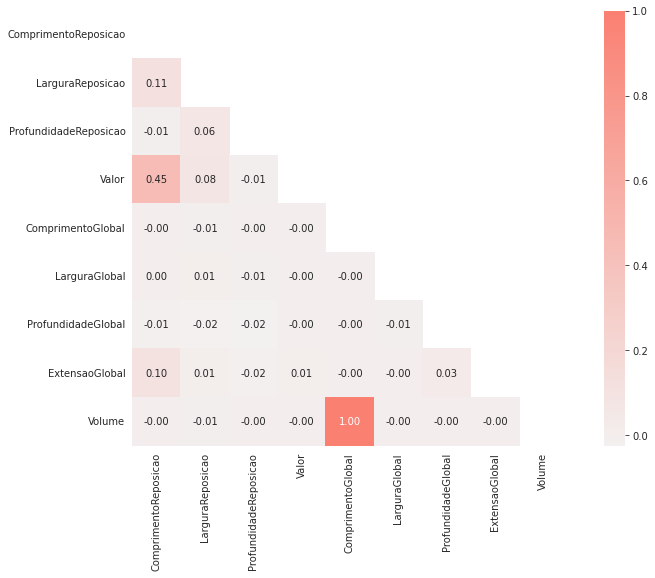

In [637]:
# Visualizando a correlação:

cores = sns.color_palette('light:salmon', as_cmap=True)
mask = np.zeros_like(correlacao)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(13, 8))
    ax = sns.heatmap(correlacao, cmap=cores, mask=mask, square=True, fmt='.2f', annot=True)

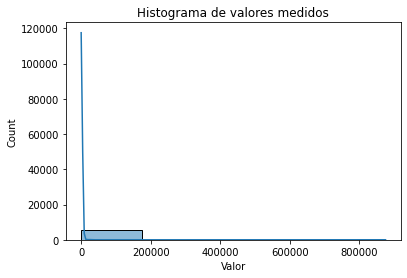

In [638]:
# Distribuição da variável resposta:

ax = sns.histplot(data=treino, x='Valor', kde=True, bins=5)
ax.set_title('Histograma de valores medidos')
ax.set_xlabel('Valor');

In [551]:
treino.dtypes

TSEReposicao              object
UGR                       object
ComprimentoReposicao     float64
LarguraReposicao         float64
ProfundidadeReposicao    float64
Valor                    float64
TSEGlobal                 object
TipoMaterial              object
PosicaoRede               object
DiametroRede              object
DiametroRamal             object
DiametroCavalete          object
ComprimentoGlobal        float64
LarguraGlobal            float64
ProfundidadeGlobal       float64
ExtensaoGlobal           float64
MND                       object
Volume                   float64
Frente                    object
dtype: object

In [639]:
# Transformação das variaveis

from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p, validate=True)
dados_transformados = transformer.transform(treino.select_dtypes(exclude=['object']))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [642]:
colunas_dados_tranformados = treino.select_dtypes(exclude=['object']).columns

df_transformado = pd.concat([treino.select_dtypes(include=['object']), pd.DataFrame(dados_transformados, columns=colunas_dados_tranformados)], axis=1)
df_transformado.head()

,TSEReposicao,UGR,TSEGlobal,TipoMaterial,PosicaoRede,DiametroRede,DiametroRamal,DiametroCavalete,MND,Frente,ComprimentoReposicao,LarguraReposicao,ProfundidadeReposicao,Valor,ComprimentoGlobal,LarguraGlobal,ProfundidadeGlobal,ExtensaoGlobal,Volume
0,733000,277,286000,0,0,0,0,0,Não,04,0.693147,0.693147,0.000000,4.696472,0.0,0.0,0.000000,0.0,0.0
1,904200,273,764500,0,0,0,0,0,Não,99,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,733000,277,286000,FF,TA,75,DN_20,0,Sim,04,1.098612,0.916291,0.000000,4.696472,0.0,0.0,0.470004,0.0,0.0
3,745000,273,0,0,0,0,0,0,Não,99,0.693147,0.693147,1.386294,0.000000,0.0,0.0,0.000000,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147,0.693147,0.000000,4.696472,0.0,0.0,0.000000,0.0,0.0


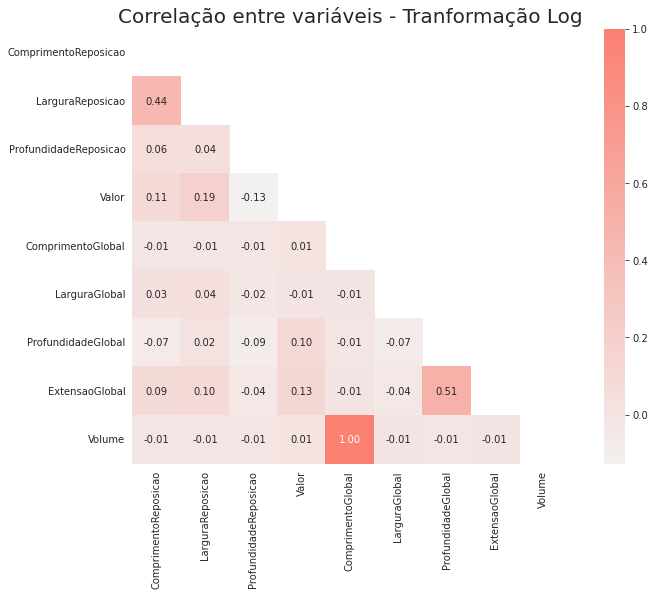

In [643]:
# Correlação pós-transformação:

correlacao_transformado = df_transformado.corr()
mask = np.zeros_like(correlacao_transformado)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(13, 8))
    ax = sns.heatmap(correlacao_transformado, cmap=cores, mask=mask, square=True, fmt='.2f', annot=True)
    ax.set_title('Correlação entre variáveis - Tranformação Log', fontsize=20)

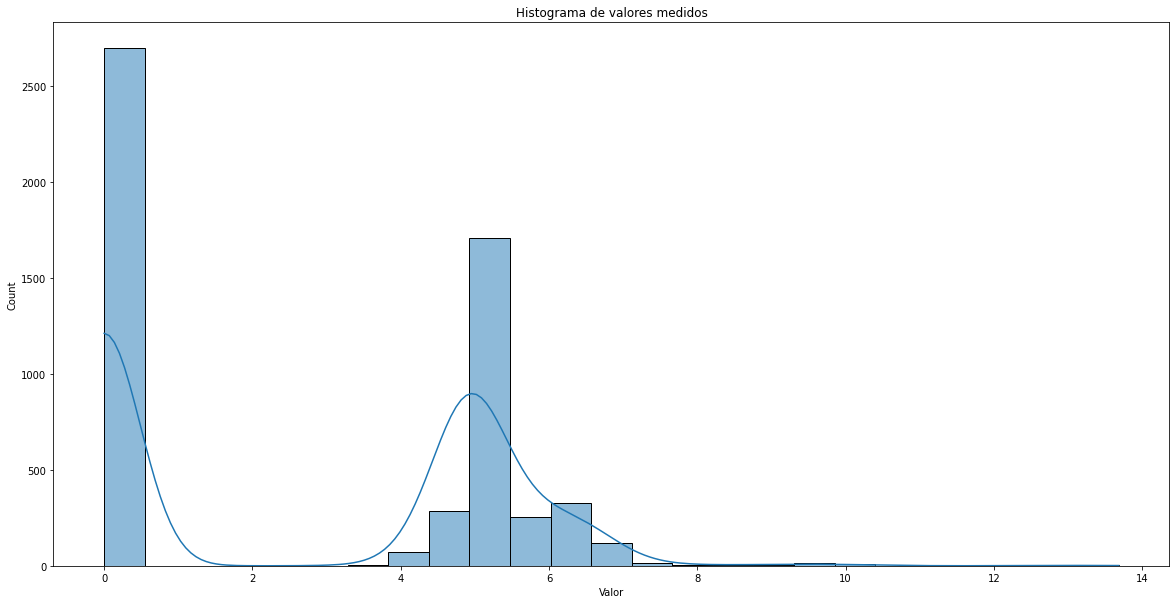

In [644]:
# Histograma pós-transformação:

ax = sns.histplot(data=df_transformado, x='Valor', kde=True)
ax.figure.set_size_inches(20, 10)
ax.set_title('Histograma de valores medidos')
ax.set_xlabel('Valor');

In [645]:
# Dummies:

variaveis_categoricas = df_transformado.select_dtypes(include=['object']).columns

In [646]:
variaveis_categoricas

Index(['TSEReposicao', 'UGR', 'TSEGlobal', 'TipoMaterial', 'PosicaoRede',
       'DiametroRede', 'DiametroRamal', 'DiametroCavalete', 'MND', 'Frente'],
      dtype='object')

In [647]:
df_dummies = pd.get_dummies(df_transformado[variaveis_categoricas])
df_dummies.head()

,TSEReposicao_211000,TSEReposicao_700500,TSEReposicao_730000,TSEReposicao_730500,TSEReposicao_731000,TSEReposicao_732000,TSEReposicao_733000,TSEReposicao_734000,TSEReposicao_738000,TSEReposicao_743000,...,MND_Não,MND_Sim,Frente_00,Frente_01,Frente_02,Frente_03,Frente_04,Frente_05,Frente_06,Frente_99
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [648]:
treino_dummies = pd.concat([df_transformado.drop(variaveis_categoricas, axis=1), df_dummies], axis=1) 
treino_dummies.head()

,ComprimentoReposicao,LarguraReposicao,ProfundidadeReposicao,Valor,ComprimentoGlobal,LarguraGlobal,ProfundidadeGlobal,ExtensaoGlobal,Volume,TSEReposicao_211000,...,MND_Não,MND_Sim,Frente_00,Frente_01,Frente_02,Frente_03,Frente_04,Frente_05,Frente_06,Frente_99
0,0.693147,0.693147,0.000000,4.696472,0.0,0.0,0.000000,0.0,0.0,0,...,1,0,0,0,0,0,1,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,...,1,0,0,0,0,0,0,0,0,1
2,1.098612,0.916291,0.000000,4.696472,0.0,0.0,0.470004,0.0,0.0,0,...,0,1,0,0,0,0,1,0,0,0
3,0.693147,0.693147,1.386294,0.000000,0.0,0.0,0.000000,0.0,0.0,0,...,1,0,0,0,0,0,0,0,0,1
4,0.693147,0.693147,0.000000,4.696472,0.0,0.0,0.000000,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [663]:
df_transformado.isna().sum()

TSEReposicao             871
UGR                      871
TSEGlobal                871
TipoMaterial             871
PosicaoRede              871
DiametroRede             871
DiametroRamal            871
DiametroCavalete         871
MND                      871
Frente                   871
ComprimentoReposicao     871
LarguraReposicao         871
ProfundidadeReposicao    871
Valor                    871
ComprimentoGlobal        871
LarguraGlobal            871
ProfundidadeGlobal       871
ExtensaoGlobal           871
Volume                   871
dtype: int64

In [649]:
# Regressão Linear:

# Divisão dos dados:
# Variáveis explanatórias:
X = treino_dummies.drop('Valor', axis=1)

# Variável dependente:
y = treino_dummies['Valor']

In [652]:
# Divisão em conjunto de treino e teste:

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [654]:
y.dtypes

dtype('float64')

In [656]:
y.isna().sum()

871

In [658]:
treino['Valor'].isna().sum()

0

In [659]:
# Modelo de Regressão Linear

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train+1)

ValueError: ignored